<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/4_Introduccion_a_RNN_y_Vanilla_RNN_Solucionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 4: Introducción a RNN y Vanilla RNN



*Adaptado de: https://www.tensorflow.org/tutorials/structured_data/time_series*

Probaremos los siguiente con este problema de Time Series:

* Forecast de un timestep simple:
  * Un feature.
  * Todos los features.
* Forecast de múltiples steps:
  * Single-shot: predicciones de todos al mismo tiempo.
  * Autoregressive: hacer una predicción cada vez y considerarlo como feedback al modelo.

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False

## Weather dataset
Usaremos <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> gracias al instituto <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck for Biogeochemistry</a>.

Este conjunto de datos contiene 14 características diferentes, como la temperatura del aire, la presión atmosférica y la humedad. Estos se recopilaron cada 10 minutos, a partir de 2003. Para mayor eficiencia, utilizará solo los datos recopilados entre 2009 y 2016. Esta sección del conjunto de datos fue preparada por François Chollet para su libro.[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


Sólo nos centraremos en realizar  **predicciones por hora**, así que haremos un subsampling de los datos en intervalos de 10 minutos a 1h:

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Echemos un vistazo a los datos:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

Este es el comportamiento de algunos features en el tiempo

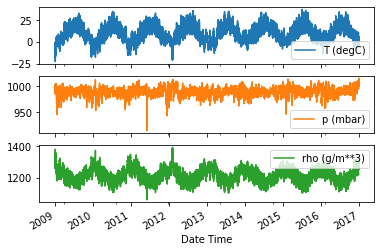

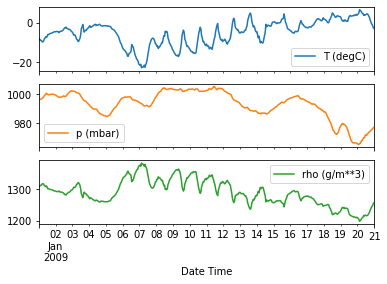

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Análisis y limpieza

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

Una cosa que debe destacarse es el valor "min" de la velocidad del viento, las columnas "wv (m / s)" y "max. wv (m / s)". Este "-9999" es probablemente erróneo. Hay una columna de dirección del viento separada, por lo que la velocidad debe ser `> = 0`. Lo reemplazaremos con ceros:


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Antes de sumergirse en la construcción de un modelo, es importante comprender sus datos y asegurarse de pasar los datos con el formato adecuado.

#### Wind
La última columna del dataset, "wd (deg)", da la dirección del viento en unidades de grados. Los ángulos no son buenas entradas de modelo, 360 ° y 0 ° deben estar cerca uno del otro y envolverse suavemente. La dirección no debería importar si el viento no sopla.

En este momento, la distribución de datos de viento se ve así:

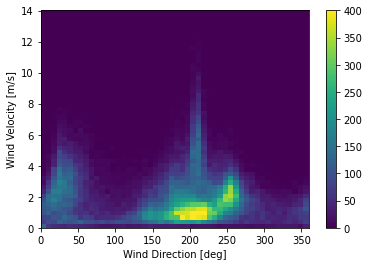

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

Pero esto será más fácil de interpretar para el modelo si convierte las columnas de dirección y velocidad del viento en un viento **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

De esta manera, la distribución del vector viento es mucho más simple de interpretar para el modelo:

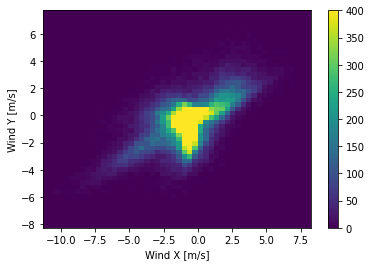

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

#### Time

Del mismo modo, la columna "Date Time" es muy útil, pero no en esta forma de cadena. Convirtámosla a segundos:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar a la dirección del viento, el tiempo en segundos no es una entrada útil del modelo. Siendo datos meteorológicos, tiene una clara periodicidad diaria y anual. Hay muchas maneras de lidiar con la periodicidad.

Un enfoque simple para convertirlo en una señal utilizable es usar "sin" y "cos" para convertir la hora para borrar las señales de "Hora del día" y "Hora del año":

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

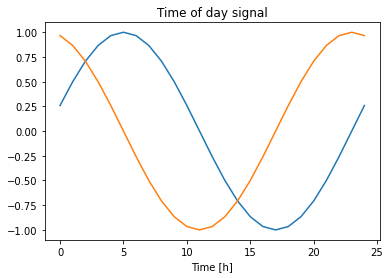

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

Esto le da al modelo acceso a las funciones de frecuencia más importantes. En este caso, sabíamos de antemano qué frecuencias eran importantes.

Si no lo sabía, puede determinar qué frecuencias son importantes utilizando un `fft`. Para verificar nuestras suposiciones, aquí está el `tf.signal.rfft` de la temperatura a lo largo del tiempo. Tenga en cuenta los picos obvios en frecuencias cercanas a `1 / año` y` 1 / día`:

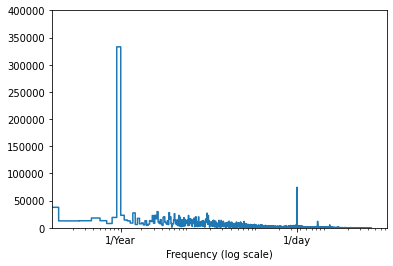

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

Usaremos una división 70%, 20%, 10% para los conjuntos de entrenamiento, validación y prueba. Tenga en cuenta que los datos **no** se barajan aleatoriamente antes de dividirlos. Esto es por dos razones.

1. Se asegura que es posible cortar los datos en ventanas de muestras consecutivas.
2. Se asegura que los resultados de validación / prueba sean más realistas y se evalúen según los datos recopilados después de que el modelo fue entrenado.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalizar los datos

Restamos la media y dividimos por la desviación estándar de cada feature.

La media y la desviación estándar solo deben calcularse utilizando los datos de entrenamiento para que los modelos no tengan acceso a los valores en los conjuntos de validación y prueba.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Ahora observemos la distribución de las características. Algunas características tienen colas largas, pero no hay errores obvios como el valor de la velocidad del viento `-9999`.

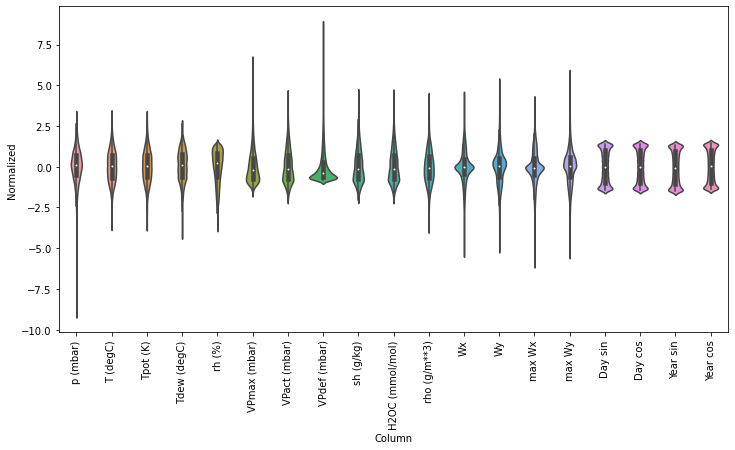

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

Se realizarán un conjunto de predicciones basadas en una ventana de muestras consecutivas de los datos (data  windowing).

Las principales características de las ventanas de entrada son:

* El ancho (número de pasos de tiempo) de las ventanas de entrada y etiqueta
* La diferencia de tiempo entre ellos.
* Qué funciones se utilizan como entradas, etiquetas o ambas.

Esta sección se centra en la implementación de la ventana de datos para que pueda reutilizarse para todos esos modelos.



Según la tarea y el tipo de modelo, es posible que desee generar una variedad de ventanas de datos. Aquí hay unos ejemplos:

1. Por ejemplo, para hacer una sola predicción 24 horas en el futuro, dadas 24 horas de historial, puede definir una ventana como esta:

  ![One prediction 24h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. Un modelo que hace una predicción 1h en el futuro, dadas 6h de historia, necesitaría una ventana como esta:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

El resto de esta sección define una clase "WindowGenerator". Esta clase puede:

1. Manejar los índices y compensaciones como se muestra en los diagramas de arriba.
1. Dividir las ventanas de características en pares "(características, etiquetas)".
2. Trazar el contenido de las ventanas resultantes.
3. Generar de manera eficiente lotes de estas ventanas a partir de los datos de entrenamiento, evaluación y prueba, utilizando "tf.data.Dataset".

### 1. Indexes and offsets


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Aquí hay un código para crear las 2 ventanas que se muestran en los diagramas al comienzo de esta sección:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Dada una lista de entradas consecutivas, el método `split_window` las convertirá en una ventana de entradas y una ventana de etiquetas.

El ejemplo `w2`, anterior, se dividirá así:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

Este diagrama no muestra el eje `features` de los datos, pero esta función` split_window` también maneja las `label_columns` por lo que se puede usar tanto para los ejemplos de salida única como para los de múltiples salidas.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


El código anterior tomó un lote de 2 ventanas de 7 pasos de tiempo, con 19 features en cada paso de tiempo. Los dividió en un lote de 6 pasos de tiempo, 19 features y una etiqueta de 1 paso de tiempo y 1 feature. La etiqueta solo tiene una característica porque el `WindowGenerator` se inicializó con` label_columns = ['T (degC)'] `.

### 3. Plot

Aquí hay un método de trazado que permite una visualización simple de la ventana dividida:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Este gráfico alinea las entradas, las etiquetas y las predicciones (posteriores) en función del tiempo al que se refiere el elemento:

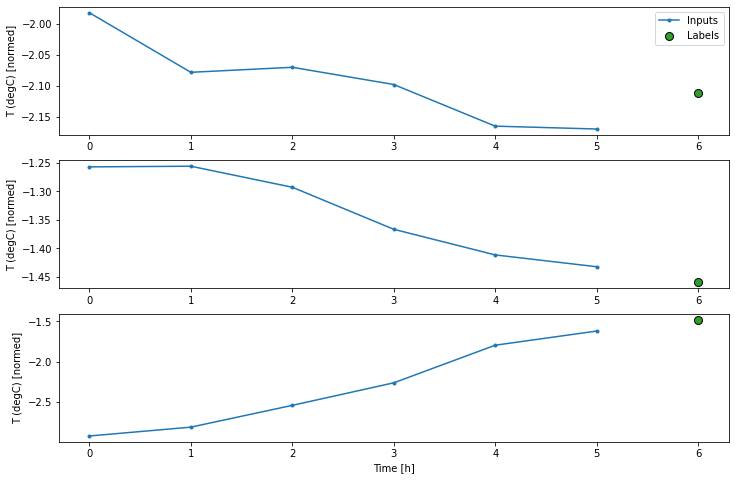

In [ ]:
w2.plot()

Puede trazar las otras columnas, pero la configuración de la ventana de ejemplo `w2` solo tiene etiquetas para la columna` T (degC) `.

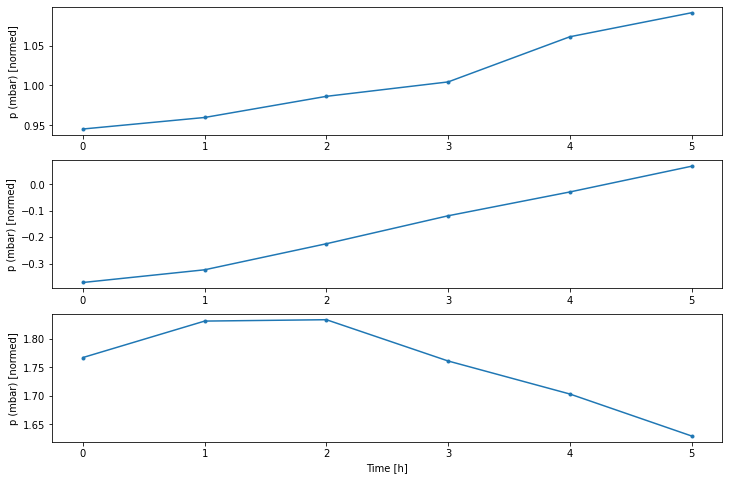

In [ ]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finalmente, este método `make_dataset` tomará una serie de tiempo` DataFrame` y la convertirá en un `tf.data.Dataset` de pares` (input_window, label_window) `usando la función` preprocessing.timeseries_dataset_from_array`.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

El objeto `WindowGenerator` contiene datos de entrenamiento, validación y prueba. Agregue propiedades para acceder a ellas como `tf.data.Datasets` usando el método anterior` make_dataset`. También agregue un lote de ejemplo estándar para facilitar el acceso y el trazado:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ahora el objeto `WindowGenerator` le da acceso a los objetos` tf.data.Dataset`, por lo que puede iterar fácilmente sobre los datos.

La propiedad `Dataset.element_spec` te dice la estructura,` dtypes` y formas de los elementos del conjunto de datos.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

La iteración sobre un `Dataset` produce lotes concretos:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

El modelo más simple que puede construir a partir de este tipo de datos es uno que predice el valor de una sola característica, 1 paso de tiempo (1h) en el futuro basado solo en las condiciones actuales.

Así que comience por construir modelos para predecir el valor de 'T (degC)' 1h en el futuro.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure un objeto `WindowGenerator` para producir estos pares` (entrada, etiqueta) `de un solo paso:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

El objeto `window` crea` tf.data.Datasets` a partir de los conjuntos de entrenamiento, validación y prueba, lo que le permite iterar fácilmente sobre lotes de datos.



In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


Finalmente construimos nuestro window y creamos el método compile_and_fit que contiene los pasos de compilación y entrenamiento de la arquitectura que generemos

In [ ]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

Epoch 1/10
1534/1534 [==============================] - 22s 11ms/step - loss: 0.1925 - mean_absolute_error: 0.2686 - val_loss: 0.0118 - val_mean_absolute_error: 0.0811
Epoch 2/10
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0100 - mean_absolute_error: 0.0742 - val_loss: 0.0091 - val_mean_absolute_error: 0.0710
Epoch 3/10
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0092 - mean_absolute_error: 0.0707 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700
Epoch 4/10
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0087 - val_mean_absolute_error: 0.0690
Epoch 5/10
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0691
Epoch 6/10
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0088 - val_mean_absolute_error: 0.07

In [ ]:
test_performance = linear.evaluate(single_step_window.test, verbose=1)

220/220 [==============================] - 1s 6ms/step - loss: 0.0085 - mean_absolute_error: 0.0677


### Recurrent neural network

Una red neuronal recurrente (RNN) es un tipo de red neuronal muy adecuada para datos de series de tiempo. Los RNN procesan una serie de tiempo paso a paso, manteniendo un estado interno de un paso de tiempo a otro paso de tiempo.

Utilizaremos una capa RNN llamada SimpleRNN ([SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)).

Un argumento de constructor importante para todas las capas de keras RNN es el argumento `return_sequences`. Esta configuración puede definir la capa de dos formas.

1. Si es "Falso", el valor predeterminado, la capa solo devuelve el resultado del paso de tiempo final, lo que le da tiempo al modelo para calentar su estado interno antes de hacer una sola predicción:

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. Si es "Verdadero", la capa devuelve una salida para cada entrada. Esto es útil para:
  * Apilamiento de capas RNN.
  * Entrenamiento de un modelo en múltiples pasos de tiempo simultáneamente.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

In [ ]:
rnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Con `return_sequences = True` el modelo se puede entrenar en 24 horas de datos a la vez.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', rnn_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(rnn_model, wide_window)

# IPython.display.clear_output()

Epoch 1/10
1533/1533 [==============================] - 53s 34ms/step - loss: 0.0380 - mean_absolute_error: 0.1112 - val_loss: 0.0087 - val_mean_absolute_error: 0.0676
Epoch 2/10
1533/1533 [==============================] - 53s 34ms/step - loss: 0.0079 - mean_absolute_error: 0.0633 - val_loss: 0.0070 - val_mean_absolute_error: 0.0597
Epoch 3/10
1533/1533 [==============================] - 50s 33ms/step - loss: 0.0068 - mean_absolute_error: 0.0581 - val_loss: 0.0065 - val_mean_absolute_error: 0.0570
Epoch 4/10
1533/1533 [==============================] - 52s 34ms/step - loss: 0.0065 - mean_absolute_error: 0.0565 - val_loss: 0.0063 - val_mean_absolute_error: 0.0563
Epoch 5/10
1533/1533 [==============================] - 52s 34ms/step - loss: 0.0063 - mean_absolute_error: 0.0555 - val_loss: 0.0061 - val_mean_absolute_error: 0.0548
Epoch 6/10
1533/1533 [==============================] - 72s 47ms/step - loss: 0.0062 - mean_absolute_error: 0.0549 - val_loss: 0.0061 - val_mean_absolute_error:

In [ ]:
val_performance = {}
performance = {}
val_performance['SimpleRNN'] = rnn_model.evaluate(wide_window.val)
performance['SimpleRNN'] = rnn_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 4s 10ms/step - loss: 0.0059 - mean_absolute_error: 0.0535


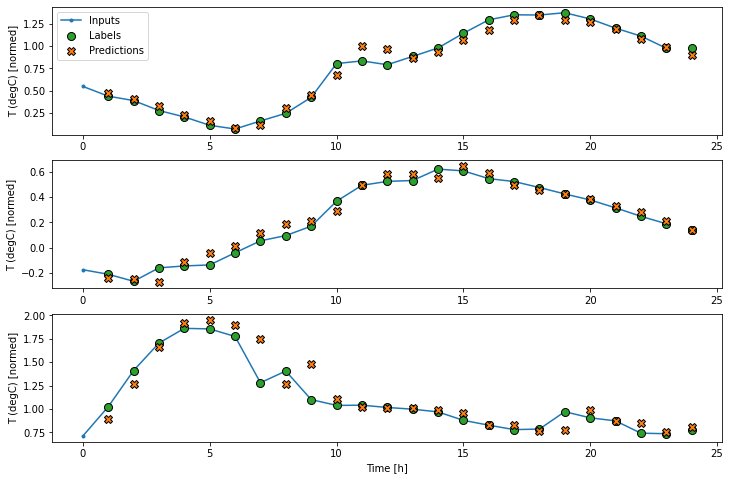

In [ ]:
wide_window.plot(rnn_model)

### Performance

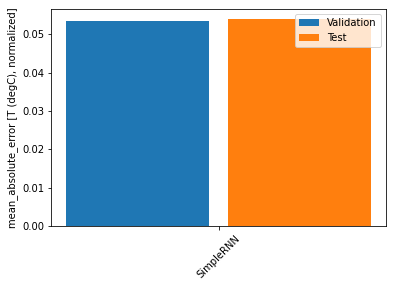

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = rnn_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

SimpleRNN   : 0.0539


### Multi-output models

Hasta ahora, sólo hemos hecho la predicción de una característica de salida única, 'T (degC)', para un solo paso de tiempo.

Sin embargo podemos predecir múltiples características simplemente cambiando el número de unidades en la capa de salida y ajustando las ventanas de entrenamiento para incluir todas las características en las "etiquetas".



In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Tenga en cuenta que el eje "features" de las etiquetas ahora tiene la misma profundidad que las entradas, en lugar de 1.

#### RNN



In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

rnn_multioutput_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(rnn_multioutput_model, wide_window)

val_performance['multioutput_SimpleRNN'] = rnn_multioutput_model.evaluate( wide_window.val)
performance['multioutput_SimpleRNN'] = rnn_multioutput_model.evaluate( wide_window.test, verbose=0)

print()

Epoch 1/10
1533/1533 [==============================] - 53s 34ms/step - loss: 0.1281 - mean_absolute_error: 0.2125 - val_loss: 0.0712 - val_mean_absolute_error: 0.1448
Epoch 2/10
1533/1533 [==============================] - 53s 35ms/step - loss: 0.0696 - mean_absolute_error: 0.1394 - val_loss: 0.0672 - val_mean_absolute_error: 0.1335
Epoch 3/10
1533/1533 [==============================] - 52s 34ms/step - loss: 0.0673 - mean_absolute_error: 0.1327 - val_loss: 0.0662 - val_mean_absolute_error: 0.1302
Epoch 4/10
1533/1533 [==============================] - 52s 34ms/step - loss: 0.0663 - mean_absolute_error: 0.1297 - val_loss: 0.0656 - val_mean_absolute_error: 0.1282
Epoch 5/10
1533/1533 [==============================] - 51s 34ms/step - loss: 0.0656 - mean_absolute_error: 0.1279 - val_loss: 0.0647 - val_mean_absolute_error: 0.1266
Epoch 6/10
1533/1533 [==============================] - 52s 34ms/step - loss: 0.0651 - mean_absolute_error: 0.1268 - val_loss: 0.0642 - val_mean_absolute_error:

In [ ]:
performance['multioutput_SimpleRNN']

[0.0633564367890358, 0.12473249435424805]

#### Performance

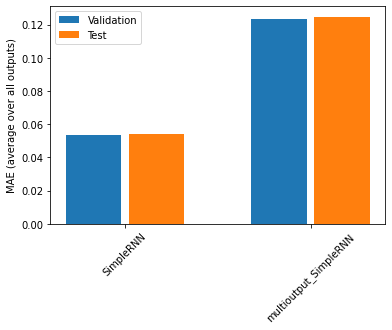

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = rnn_multioutput_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

SimpleRNN      : 0.0539
multioutput_SimpleRNN: 0.1247


## Multi-step models

Tanto el modelo de salida única como el de salida múltiple de las secciones anteriores realizaron **predicciones de paso de tiempo único**, 1h en el futuro.

En esta sección se analiza cómo expandir estos modelos para realizar **predicciones de múltiples pasos de tiempo**.

En una predicción de varios pasos, el modelo debe aprender a predecir un rango de valores futuros. Por lo tanto, a diferencia de un modelo de un solo paso, donde solo se predice un único punto futuro, un modelo de múltiples pasos predice una secuencia de los valores futuros.

Hay dos enfoques aproximados para esto:

1. One-shot predictions donde se predice toda la serie de tiempo a la vez.
2. Autoregressive models donde solo se hace predicciones de un solo paso y su salida se retroalimenta como su entrada.

En esta sección, todos los modelos predecirán **todas las características en todos los pasos de tiempo de salida**.



Para el modelo de varios pasos, los datos de entrenamiento nuevamente constan de muestras por hora. Sin embargo, aquí, los modelos aprenderán a predecir las 24 horas del futuro, dadas las 24 horas del pasado.

Aquí hay un objeto "Ventana" que genera estos cortes a partir 

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

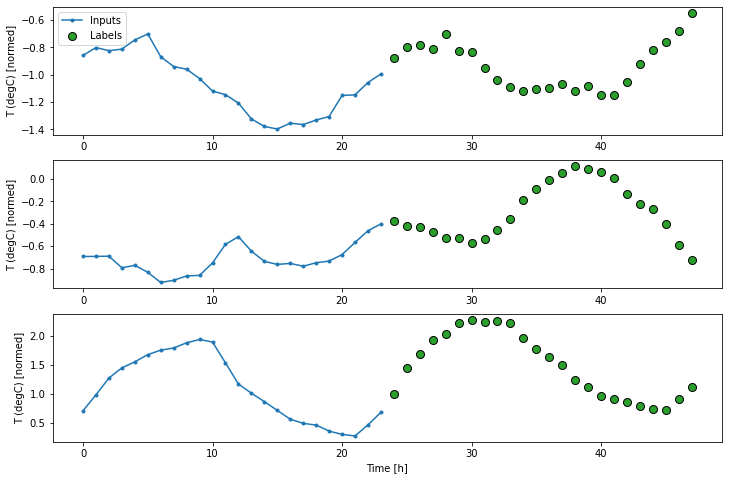

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Single shot model

#### RNN

La red recurrente acumulará en su estado interno los cálculos sobre los datos de una ventana de tiempo de 24h. En este formato, solo es necesario generar una salida, por lo que el parámetro return_sequences estará con el valor de Falso en la capa de SimpleRNN.

![Single shot model - RNN](https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png)


In [ ]:
rnn_singleshot_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(rnn_singleshot_model, multi_window)

val_performance['singleshot_SimpleRNN'] = rnn_singleshot_model.evaluate( multi_window.val)
performance['singleshot_SimpleRNN'] = rnn_singleshot_model.evaluate( multi_window.test, verbose=0)

print()

Epoch 1/10
1532/1532 [==============================] - 53s 34ms/step - loss: 0.2963 - mean_absolute_error: 0.3663 - val_loss: 0.2461 - val_mean_absolute_error: 0.3187
Epoch 2/10
1532/1532 [==============================] - 50s 33ms/step - loss: 0.2333 - mean_absolute_error: 0.3062 - val_loss: 0.2339 - val_mean_absolute_error: 0.3036
Epoch 3/10
1532/1532 [==============================] - 52s 34ms/step - loss: 0.2259 - mean_absolute_error: 0.2971 - val_loss: 0.2286 - val_mean_absolute_error: 0.2976
Epoch 4/10
1532/1532 [==============================] - 50s 33ms/step - loss: 0.2223 - mean_absolute_error: 0.2929 - val_loss: 0.2282 - val_mean_absolute_error: 0.2961
Epoch 5/10
1532/1532 [==============================] - 50s 33ms/step - loss: 0.2196 - mean_absolute_error: 0.2899 - val_loss: 0.2237 - val_mean_absolute_error: 0.2923
Epoch 6/10
1532/1532 [==============================] - 49s 32ms/step - loss: 0.2179 - mean_absolute_error: 0.2881 - val_loss: 0.2236 - val_mean_absolute_error:

#### Performance

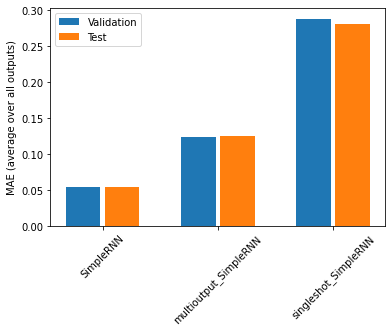

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = rnn_singleshot_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Advanced: Autoregressive model

El modelo anterior predice la secuencia de salida completa en un solo paso.

En algunos casos, puede ser útil que el modelo descomponga esta predicción en pasos de tiempo individuales. Luego, la salida de cada modelo se puede retroalimentar en cada paso y se pueden hacer predicciones condicionadas al anterior.

Una clara ventaja de este estilo de modelo es que se puede configurar para producir resultados con una longitud variable.

Puede tomar el modelo de salida múltiple de un solo paso entrenado en la primera mitad de este tutorial y ejecutarlo en un ciclo de retroalimentación autorregresivo, pero aquí nos enfocaremos en construir un modelo que haya sido entrenado explícitamente para hacer eso.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)




#### RNN

Construiremos un modelo RNN autorregresivo, pero este patrón podría aplicarse a cualquier modelo que fue diseñado para generar un único paso de tiempo.

El modelo tendrá la misma forma básica que los modelos `RNN` de un solo paso: un` RNN` seguido de un `layer.Dense` que convierte las salidas de` RNN` en predicciones del modelo.

Un `layer.LSTM` es un` layer.LSTMCell` envuelto en el nivel superior de `layer.RNN` que administra el estado y los resultados de secuencia por usted.

En este caso, el modelo tiene que administrar manualmente las entradas para cada paso, por lo que utiliza `layer.LSTMCell` directamente para el nivel inferior, la interfaz de un solo paso de tiempo.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

El primer método que necesita este modelo es un método de "warmup" para inicializar su estado interno basado en las entradas. Una vez entrenado, este estado capturará las partes relevantes del historial de entrada. Esto es equivalente al modelo `LSTM` de un solo paso anterior:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Este método devuelve una única predicción de paso de tiempo y el estado interno del LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Con el estado de "RNN" y una predicción inicial, ahora puede continuar iterando el modelo alimentando las predicciones en cada paso hacia atrás como entrada.

El enfoque más simple para recopilar las predicciones de salida es usar una lista de Python y `tf.stack` después del ciclo.

Nota: Apilar una lista de Python como esta solo funciona con ejecución ansiosa, usando `Model.compile (..., run_eagerly = True)` para entrenamiento, o con una salida de longitud fija. Para una longitud de salida dinámica, necesitaría usar un `tf.TensorArray` en lugar de una lista de python, y` tf.range` en lugar del `range` de python.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Pruebe este modelo en las entradas de ejemplo:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Ahora entrena el modelo:

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

Epoch 1/10
1532/1532 [==============================] - 137s 86ms/step - loss: 0.3163 - mean_absolute_error: 0.3874 - val_loss: 0.2552 - val_mean_absolute_error: 0.3364
Epoch 2/10
1532/1532 [==============================] - 135s 88ms/step - loss: 0.2343 - mean_absolute_error: 0.3175 - val_loss: 0.2415 - val_mean_absolute_error: 0.3221
Epoch 3/10
1532/1532 [==============================] - 131s 85ms/step - loss: 0.2250 - mean_absolute_error: 0.3067 - val_loss: 0.2341 - val_mean_absolute_error: 0.3112
Epoch 4/10
1532/1532 [==============================] - 133s 87ms/step - loss: 0.2192 - mean_absolute_error: 0.3004 - val_loss: 0.2279 - val_mean_absolute_error: 0.3049
Epoch 5/10
1532/1532 [==============================] - 132s 86ms/step - loss: 0.2159 - mean_absolute_error: 0.2966 - val_loss: 0.2284 - val_mean_absolute_error: 0.3039
Epoch 6/10
1532/1532 [==============================] - 134s 87ms/step - loss: 0.2124 - mean_absolute_error: 0.2932 - val_loss: 0.2258 - val_mean_absolute_

437/437 [==============================] - 7s 15ms/step - loss: 0.2238 - mean_absolute_error: 0.2985


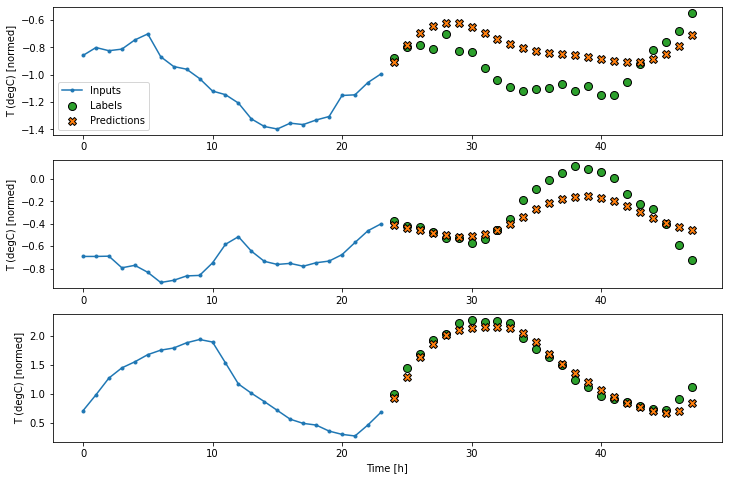

In [ ]:
multi_val_performance = {}
multi_performance = {}
multi_val_performance['AR RNN'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR RNN'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

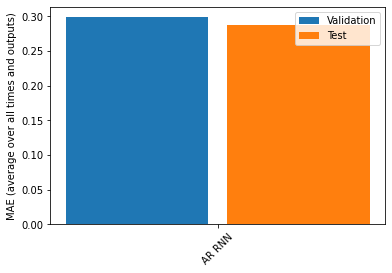

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

AR RNN  : 0.2878


## Preguntas adicionales

**Pregunta: Construir un modelo que permita generar la salida del siguiente instante de tiempo**

Considerar:
- Aplicar return_sequences como Falso
- Definir el label width como 1

Tomar en cuenta el siguiente diagrama:

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

In [ ]:
#Complete
wide_window = WindowGenerator(
    input_width = 24, 
    label_width = 1, 
    shift = 1,
    label_columns = ['T (degC)'])

single_rnn = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(32, return_sequences = False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(single_rnn, wide_window)

Epoch 1/10
1533/1533 [==============================] - 54s 34ms/step - loss: 0.0189 - mean_absolute_error: 0.0952 - val_loss: 0.0084 - val_mean_absolute_error: 0.0657
Epoch 2/10
1533/1533 [==============================] - 48s 31ms/step - loss: 0.0082 - mean_absolute_error: 0.0652 - val_loss: 0.0072 - val_mean_absolute_error: 0.0603
Epoch 3/10
1533/1533 [==============================] - 54s 35ms/step - loss: 0.0074 - mean_absolute_error: 0.0612 - val_loss: 0.0068 - val_mean_absolute_error: 0.0584
Epoch 4/10
1533/1533 [==============================] - 49s 32ms/step - loss: 0.0070 - mean_absolute_error: 0.0594 - val_loss: 0.0068 - val_mean_absolute_error: 0.0584
Epoch 5/10
1533/1533 [==============================] - 50s 32ms/step - loss: 0.0069 - mean_absolute_error: 0.0587 - val_loss: 0.0064 - val_mean_absolute_error: 0.0566
Epoch 6/10
1533/1533 [==============================] - 49s 32ms/step - loss: 0.0067 - mean_absolute_error: 0.0578 - val_loss: 0.0063 - val_mean_absolute_error:

**Pregunta: Construir un modelo multi-output, cambie la capa SimpleRNN por capas densas y compare los resultados que obtenga.**

Sugerencias: 
- Reutilice código de la sección de multi-output models para apoyarse
- Puede revisar el enlace https://www.tensorflow.org/tutorials/structured_data/time_series si es que desea revisar cómo se podría aplicar la capa densa

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

dense_multioutput_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense_multioutput_model, wide_window)

val_performance['multioutput_dense'] = dense_multioutput_model.evaluate( wide_window.val)
performance['multioutput_dense'] = dense_multioutput_model.evaluate( wide_window.test, verbose=0)

print()

Epoch 1/10
1533/1533 [==============================] - 15s 9ms/step - loss: 0.2448 - mean_absolute_error: 0.3188 - val_loss: 0.0868 - val_mean_absolute_error: 0.1781
Epoch 2/10
1533/1533 [==============================] - 14s 9ms/step - loss: 0.0808 - mean_absolute_error: 0.1590 - val_loss: 0.0749 - val_mean_absolute_error: 0.1444
Epoch 3/10
1533/1533 [==============================] - 15s 10ms/step - loss: 0.0769 - mean_absolute_error: 0.1463 - val_loss: 0.0747 - val_mean_absolute_error: 0.1418
Epoch 4/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0764 - mean_absolute_error: 0.1445 - val_loss: 0.0747 - val_mean_absolute_error: 0.1412
Epoch 5/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0763 - mean_absolute_error: 0.1440 - val_loss: 0.0745 - val_mean_absolute_error: 0.1404
Epoch 6/10
1533/1533 [==============================] - 16s 11ms/step - loss: 0.0762 - mean_absolute_error: 0.1437 - val_loss: 0.0746 - val_mean_absolute_error: 0

In [ ]:
mae_rnn, mse_rnn = val_performance['multioutput_SimpleRNN']
mae_dense, mse_dense = val_performance['multioutput_dense']

print(f'RNN: MAE: {mae_rnn}, MSE: {mse_rnn}')
print(f'Dense: MAE: {mae_dense}, MSE: {mse_dense}')

RNN: MAE: 0.06329596787691116, MSE: 0.12333753705024719
Dense: MAE: 0.074604332447052, MSE: 0.14087152481079102


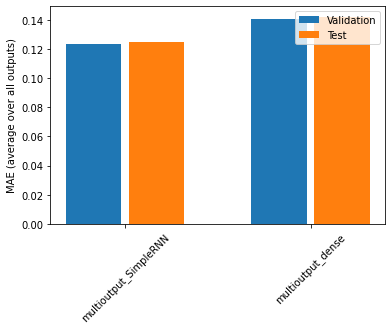

In [ ]:
x = np.arange(2)
width = 0.3

key = ['multioutput_SimpleRNN', 'multioutput_dense']
metric_index = rnn_multioutput_model.metrics_names.index('mean_absolute_error')
val_mae = [val_performance[x][metric_index] for x in key]
test_mae = [performance[x][metric_index] for x in key]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=key,
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()